# Smart start with different predefined turbine types
Smart start is a greedy algorithm that could improve your initial layout before optimization by successively placing a turbine and performing an AEP-map computation (calculating AEP for a range of grid points specified by the user).
This example shows how to use smart start on a wind farm comprised of a know number of different turbine types.

**Install TOPFARM if needed**

In [ ]:
# Install TopFarm if needed
import importlib
if not importlib.util.find_spec("topfarm"):
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/TopFarm2.git

In [ ]:
import numpy as np
from topfarm._topfarm import TopFarmProblem
from topfarm.constraint_components.boundary import CircleBoundaryConstraint
from topfarm.constraint_components.spacing import SpacingTypeConstraint
from topfarm.plotting import XYPlotComp
from topfarm.easy_drivers import EasyScipyOptimizeDriver
from topfarm.cost_models.py_wake_wrapper import PyWakeAEPCostModelComponent
from py_wake.examples.data.iea37._iea37 import IEA37Site
from py_wake.deficit_models.gaussian import IEA37SimpleBastankhahGaussian
from py_wake.wind_turbines import WindTurbines
from py_wake.wind_turbines.power_ct_functions import CubePowerSimpleCt

/Users/julianquick/miniconda3/envs/niwe2/lib/python3.11/site-packages/pyoptsparse/pyOpt_MPI.py:68: UserWarning: mpi4py could not be imported. mpi4py is required to use the parallel gradient analysis and parallel objective analysis for non-gradient based optimizers. Continuing using a dummy MPI module from pyOptSparse.
  warnings.warn(warn)



+------------------------------------------------------------------------------+
| pyOptSparse Error: There was an error importing the compiled snopt module    |
+------------------------------------------------------------------------------+



## Setup problem
Here a site with 3 different generic turbine types is instantiated. Note that here we also establish how many of each type is present in the farm; 5 x T1, 6 x T2 and 5 x T3

In [ ]:
%%capture
n_wt = 16
site = IEA37Site(n_wt)
windTurbines = WindTurbines(names=['T1', 'T2', 'T3'],
                                    diameters=[110, 130, 150],
                                    hub_heights=[110, 130, 150],
                                    powerCtFunctions = [CubePowerSimpleCt(power_rated=200 * 110 ** 2, power_unit='W'),
                                                       CubePowerSimpleCt(power_rated=200 * 130 ** 2, power_unit='W'),
                                                       CubePowerSimpleCt(power_rated=200 * 150 ** 2, power_unit='W')],)
windFarmModel = IEA37SimpleBastankhahGaussian(site, windTurbines)
init_types = 5 * [2] + 6 * [1] + 5 *[0]
tf = TopFarmProblem(
    design_vars=dict(zip('xy', site.initial_position.T)),
    cost_comp=PyWakeAEPCostModelComponent(windFarmModel, n_wt, additional_input=[('type', np.zeros(n_wt))], grad_method=None), 
    driver=EasyScipyOptimizeDriver(maxiter=30),
    constraints=[CircleBoundaryConstraint([0, 0], 1300.1),
                 SpacingTypeConstraint([windTurbines.diameter(t) * 3.5 for t in [0, 1, 2]])],
    plot_comp=XYPlotComp())
tf['type']=init_types
x = np.linspace(-1300,1300,51)
y = np.linspace(-1300,1300,51)
YY, XX = np.meshgrid(y, x)

## Evaluate and optimize the problem with and without smart start

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


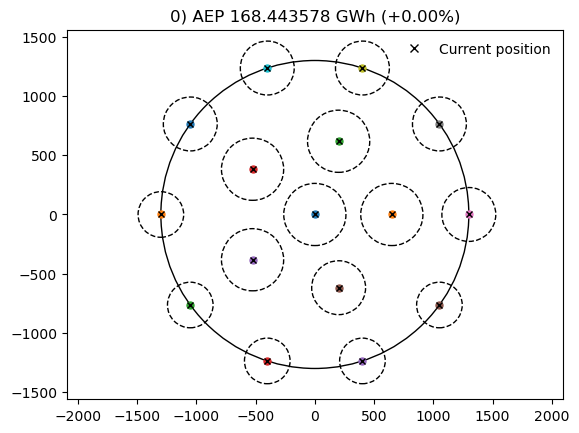

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
Iteration limit reached    (Exit mode 9)
            Current function value: -170.58698536086843
            Iterations: 50
            Function evaluations: 50
            Gradient evaluations: 50
Optimization FAILED.
Iteration limit reached
-----------------------------------


Smartstart: 100%|█████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.84it/s]

1961 possible points, 16 wt, 122.6 points pr wt, 24(1%) unused points
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


Iteration limit reached    (Exit mode 9)
            Current function value: -174.5675835428325
            Iterations: 50
            Function evaluations: 50
            Gradient evaluations: 50
Optimization FAILED.
Iteration limit reached
-----------------------------------


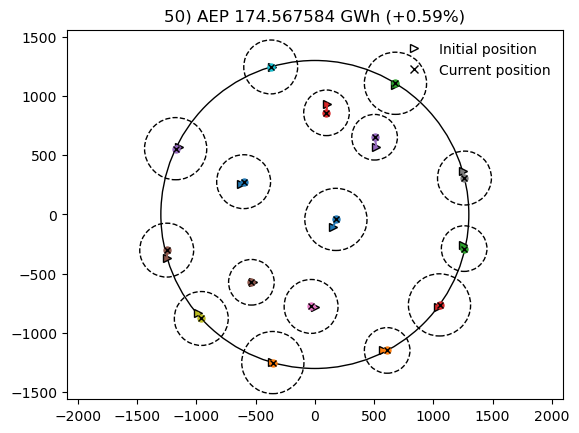

In [ ]:
# initial layout:
cost1, state1 = tf.evaluate(dict(zip('xy', site.initial_position.T)))
# initial layout + optimization:
cost2, state2, recorder2 = tf.optimize()
# smart start:
tf.smart_start(XX, YY, tf.cost_comp.get_aep4smart_start(type=init_types), seed=42)
cost3, state3 = tf.evaluate()
# smart start + optimization:
cost4, state4, recorder4 = tf.optimize()

In [ ]:
costs = [cost1, cost2, cost3, cost4]
strings = ['initial', 'initial + 50 iter. optimization', 'smart start', 'smart start + 50 iter. optimization']
for s, c in zip(strings, costs):
    print(f'{s:35}: {abs(c):.1f}')

initial                            : 168.4
initial + 50 iter. optimization    : 170.6
smart start                        : 173.5
smart start + 50 iter. optimization: 174.6
